In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 42.4 MB/s 
     |████████████████████████████████| 163 kB 49.8 MB/s 


In [ ]:
from transformers import GPT2Model

In [ ]:
model = GPT2Model.from_pretrained("gpt2-xl")

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from operator import attrgetter
def analyze_weights(model_name, model, dist_range=None, layer_names=['h']):
    parameters = torch.cat([p.flatten() for p in model.parameters()])
    hist, bin_edges = torch.histogram(torch.abs(parameters), bins=250, range=dist_range)
    bin_edges = bin_edges.detach().numpy()
    hist = hist.detach().numpy()
    width = np.diff(bin_edges)
    plt.bar(bin_edges[:-1], hist, width=width)
    plt.title("Distribution of weight magnitudes for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.show()
    
    dist = np.cumsum(hist / hist.sum(), 0)
    plt.plot(bin_edges[:-1], dist)
    plt.title("CDF of weight magnitudes for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.show()
    
    for layer_name in layer_names:
        for idx, layer in enumerate(attrgetter(layer_name)(model)):
            parameters = torch.cat([p.flatten() for p in layer.parameters()])
            hist, bin_edges = torch.histogram(torch.abs(parameters), bins=250, range=dist_range)
            bin_edges = bin_edges.detach().numpy()
            hist = hist.detach().numpy()
            dist = np.cumsum(hist / hist.sum(), 0)
            plt.plot(bin_edges[:-1], dist, label= layer_name + " layer " + str(idx))
    plt.title("CDF of weight magnitudes by layer for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()
    

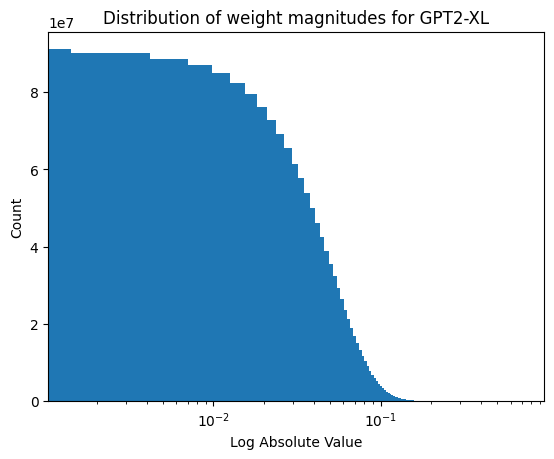

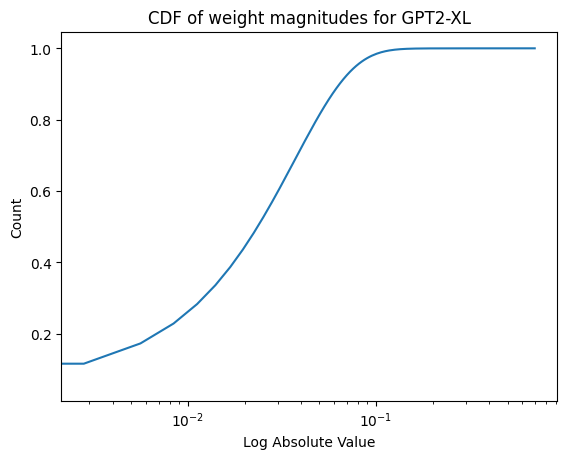

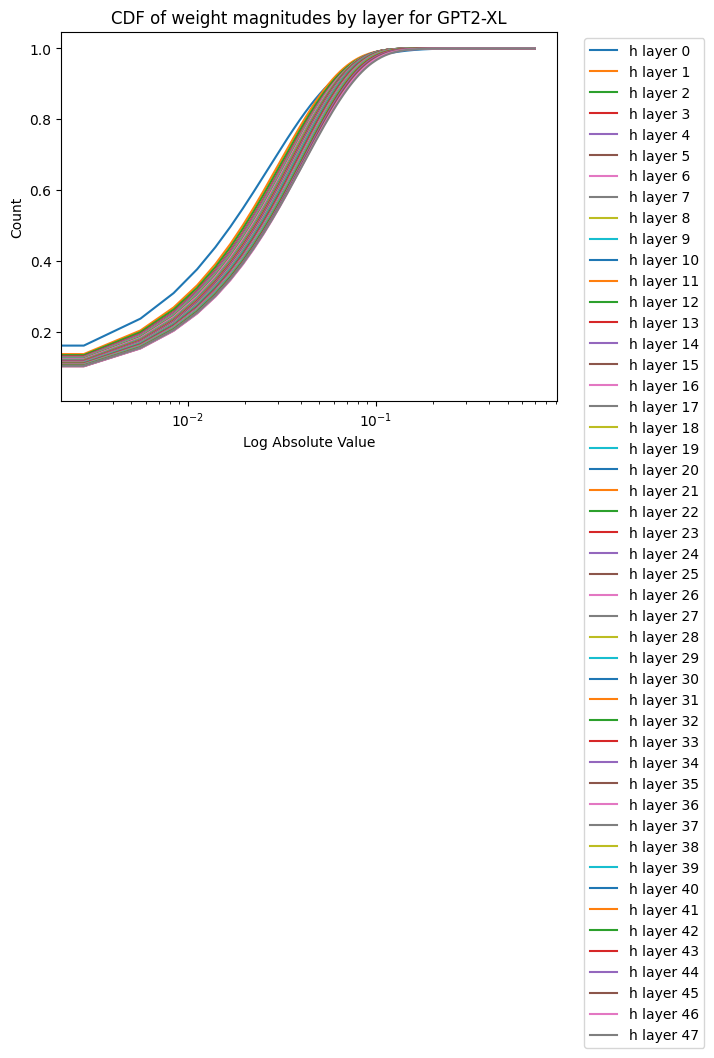

In [ ]:
analyze_weights("GPT2-XL", model, (0, 0.7))

In [5]:
from transformers import BartModel
bartmodel = BartModel.from_pretrained("facebook/bart-large")

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

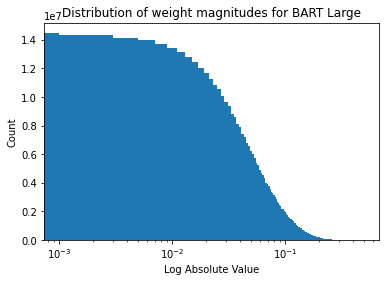

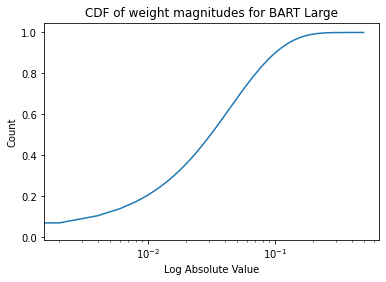

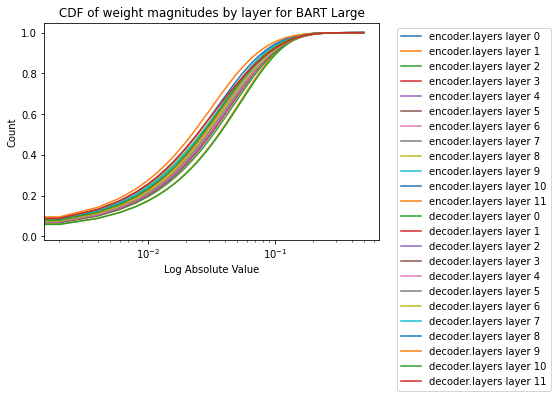

In [8]:
analyze_weights("BART Large", bartmodel, (0, 0.5), ['encoder.layers', 'decoder.layers'])

In [ ]:
from transformers import BertModel
bertmodel = BertModel.from_pretrained("bert-large-cased")

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
analyze_weights("Bert Large", bertmodel, (0, 0.7), ['encoder.layer'])

In [ ]:
from torch.nn.utils import prune
from torch.nn.modules.sparse import Embedding
def prune_weights(model, to_prune=0.1):
    def get_weight_names(layer):
        weight_names = []
        if len(list(layer.children())) > 0:
            for child in layer.children():
                if not list(child.children()):
                    for p in child.named_parameters():
                        if 'weight' in p[0] and type(child) is not Embedding:
                            weight_names.append((child, p[0]))
                else:
                    weight_names.extend(get_weight_names(child))
        
        
        return weight_names
    
    weights = get_weight_names(model)
    
    prune.global_unstructured(weights, pruning_method=prune.L1Unstructured, amount=to_prune)
    
    for layer, name in weights:
        prune.remove(layer, name)
    return model

In [ ]:
from transformers import BartModel, GPT2Model, BertModel, GPT2ForSequenceClassification, GPT2Tokenizer
import copy
gpt2 = GPT2Model.from_pretrained("gpt2")

# Follow instructions at https://github.com/huggingface/transformers/issues/9785
# to allow GPT2 to do GLUE
gpt2_glue_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define a padding token
tokenizer.pad_token = tokenizer.eos_token
gpt2_glue_model.config.pad_token_id = tokenizer.pad_token_id


gpt2_glue_model.save_pretrained("./sparse/gpt2_glue_base")
tokenizer.save_pretrained("./sparse/gpt2_glue_base")

bartmodel = BartModel.from_pretrained("facebook/bart-large")
bertmodel = BertModel.from_pretrained("bert-large-cased")
for model, model_name in [(gpt2_glue_model, 'gpt2_glue'), (gpt2, 'gpt2'), (bartmodel, 'BART'), (bertmodel, 'BERT')]:
    print("Now beginning pruning for model " + model_name)
    for sparsity in [0.1, 0.5, 0.9, 0.95, 0.99]:
        model_to_prune = copy.deepcopy(model) 
        model_pruned = prune_weights(model_to_prune, to_prune=sparsity)
        model_pruned.save_pretrained(f"./sparse/{model_name}.{sparsity}")
        if 'gpt2' in model_name:
            tokenizer.save_pretrained(f"./sparse/{model_name}.{sparsity}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identic

Now beginning pruning for model gpt2_glue
